In [1]:
import time


import pandas as pd
import numpy as np
import os
from brick import Brick
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt


Time taken for import:  2.2165162563323975


### Working on extracting the first systematic from the dataset -  stellar Density

Data use: We create a catalog of stars from DECaLS by selecting objects lying in the stellar locus (using the color cut 17 < r < 18) with PSF morphology.

Information on a per brick basis

In [2]:
hdulistBricksSouthSummary = fits.open('../bricks_data/survey-bricks-dr9-south.fits')
data_south = hdulistBricksSouthSummary[1].data
brickname_south = data_south.field('brickname')
brickid_south = data_south.field('brickid')
south_survey_is_south = data_south.field('survey_primary')

hdulistBricksNorthSummary = fits.open('../bricks_data/survey-bricks-dr9-north.fits')
data_north = hdulistBricksNorthSummary[1].data
brickname_north = data_north.field('brickname')
brickid_north = data_north.field('brickid')
survey_north = data_north.field('survey_primary')
north_survey_is_south = np.invert(survey_north)

In [7]:
print()
print("=============================== Classification Stellar Density... ==================================")
print()

start = time.time()

bricknames_south_sample = []

for filename in os.listdir('/Volumes/Astrostick/bricks_data/south/'):
    brickn = filename.replace("tractor-", "")
    brickn = brickn.replace(".fits", "")
    bricknames_south_sample.append(brickn)

bricknames_south_sample.pop()

df = pd.DataFrame(columns=['RA', 'DEC', 'GMAG', 'RMAG', 'ZMAG', 'GMR', 'RMZ'])

for no, brickname in enumerate(bricknames_south_sample):
    hdulistSingleBrick = fits.open(f'/Volumes/Astrostick/bricks_data/south/tractor-{brickname}.fits')
    data = hdulistSingleBrick[1].data

    brick = Brick(data)
    brick.initialise_brick_for_stellar_density()

    stars = brick.get_stellar_objects()


    support_df = pd.DataFrame(stars, columns=['RA', 'DEC', 'GMAG', 'RMAG', 'ZMAG', 'GMR', 'RMZ'])
    df = df.append(support_df)

    if no % 50 == 0:
        print(len(stars))
        print(no)
print(df.head())
df.describe()
df = df.drop_duplicates()
#df.to_csv('../bricks_data/galaxy_catalogue_stellar.csv', index=False)



=============================== Classification Stellar Density... ==================================

35
0


KeyboardInterrupt: 

In [55]:
df = pd.read_csv('../bricks_data/galaxy_catalogue_stellar.csv')
df.describe()



,RA,DEC,GMAG,RMAG,ZMAG,GMR,RMZ,percent_RMAG,Z_SCORE_GMAG
count,38979.000000,38979.000000,38979.000000,38979.000000,38979.000000,38979.000000,38979.000000,38979.000000,38979.000000
mean,197.397767,-2.573402,18.389805,17.529719,17.011467,0.860085,0.518252,49.539188,0.861088
std,112.116316,26.976226,0.500445,0.287154,0.511685,0.386192,0.452294,28.844617,0.456973
min,0.000972,-67.849736,17.118793,17.000078,15.016022,0.048018,-1.980566,0.000000,0.000094
25%,90.088019,-15.475750,18.003216,17.287079,16.750458,0.526363,0.202099,25.000000,0.501858
50%,221.374552,4.835213,18.360729,17.544832,17.073626,0.754274,0.344851,50.000000,0.868166
75%,309.551203,18.474837,18.750237,17.780543,17.385365,1.243645,0.699856,75.000000,1.218342
max,359.993021,35.350494,19.644421,17.999968,19.885351,1.704018,2.696612,99.000000,1.959429


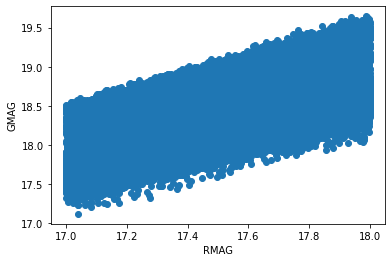

In [56]:
label_1 = 'RMAG'
label_2 = 'GMAG'

plt.scatter(df[label_1], df[label_2])
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.show()

In [57]:
# REMOVING OUTLIERS

df = df[(df['GMAG'] > 15) & (df['GMAG'] < 30) ]
df = df[(df['ZMAG'] > 15) & (df['ZMAG'] < 30) ]
df = df[(df['GMR'] > -2) & (df['GMR'] < 4) ]
df = df[(df['RMZ'] > -2) & (df['RMZ'] < 4) ]


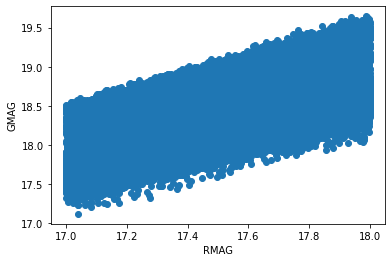

In [58]:
plt.scatter(df[label_1], df[label_2])
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.show()

In [59]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df['percent_RMAG'] = pd.qcut(df['RMAG'], q=100, labels=False)
df['percent_RMAG'].value_counts()


44    391
7     391
61    391
51    391
91    391
     ... 
81    389
9     389
77    389
95    389
45    388
Name: percent_RMAG, Length: 100, dtype: int64

In [60]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df.groupby('percent_RMAG')
zscore = lambda x: abs((x - x.median()) / x.std())
df['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)
df['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [66]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df['percent_GMR'] = pd.qcut(df['GMR'], q=100, labels=False)
df['percent_RMZ'] = pd.qcut(df['RMZ'], q=100, labels=False)
df.shape

(37894, 13)

In [67]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df.groupby('percent_GMR')
zscore = lambda x: abs((x - x.median()) / x.std())
df['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)


In [72]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df.groupby('percent_RMZ')
zscore = lambda x: abs((x - x.median()) / x.std())
df['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)


In [74]:
df['Z_SCORE_GMR'].describe()

count    37593.000000
mean         0.766507
std          0.646695
min          0.000000
25%          0.285685
50%          0.621420
75%          1.096898
max         10.341486
Name: Z_SCORE_GMR, dtype: float64

In [75]:
print(df.shape)
df = df[(df['Z_SCORE_GMR'] < 3)]
print(df.shape)
df = df[(df['Z_SCORE_RMZ'] < 3)]
df.shape

(37593, 13)
(37357, 13)


(37357, 13)

(array([ 105., 2222., 8459., 7364., 4367., 3113., 2881., 3547., 2632.,
          44.]),
 array([0.0480175 , 0.21361752, 0.37921753, 0.54481754, 0.71041756,
        0.87601757, 1.04161758, 1.2072176 , 1.37281761, 1.53841763,
        1.70401764]),
 <BarContainer object of 10 artists>)

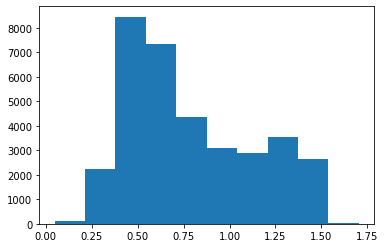

In [52]:
plt.hist(df['GMR'])

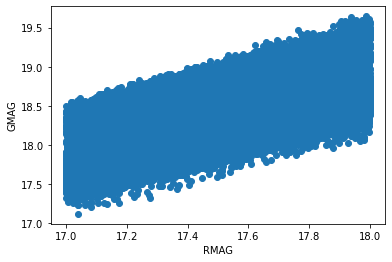

In [70]:
label_1 = 'RMAG'
label_2 = 'GMAG'

plt.scatter(df[label_1], df[label_2])
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.show()

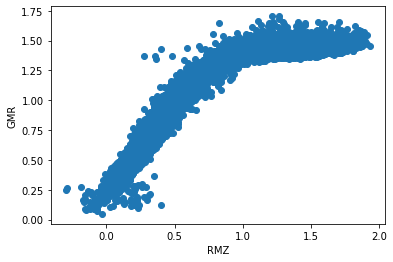

In [71]:
label_2 = 'GMR'
label_1 = 'RMZ'

plt.scatter(df[label_1], df[label_2])
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.show()

In [ ]:
df.to_csv('../bricks_data/galaxy_catalogue_stellar.csv', index=False)


In [ ]:
for no, brickname in enumerate(bricknames_south_sample):
    hdulistSingleBrick = fits.open(f'/Volumes/Astrostick/bricks_data/south_test/tractor-{brickname}.fits')
    data = hdulistSingleBrick[1].data
    ra = data.field('ra')
    dec = data.field('dec')
    brick = Brick(data)
    brick.initialise_brick_for_stellar_density()
    fluxr = brick.get_stellar_objects()
    print(len(fluxr))
    plt.hist(fluxr, range=(0,30))
    plt.show()
    

    if no == 0:
        break

In [ ]:
print("Wrong Cell")
exit()

print()
print("=============================== Classification Stellar Density... ==================================")
print()

start = time.time()

bricknames_south_sample = []

for filename in os.listdir('/Volumes/Astrostick/bricks_data/south/'):
    brickn = filename.replace("tractor-", "")
    brickn = brickn.replace(".fits", "")
    bricknames_south_sample.append(brickn)

#bricknames_south_sample.pop()
df = pd.DataFrame(columns=['RA', 'DEC'])

for no, brickname in enumerate(bricknames_south_sample):
    hdulistSingleBrick = fits.open(f'/Volumes/Astrostick/bricks_data/south/tractor-{brickname}.fits')
    data = hdulistSingleBrick[1].data

    brick = Brick(data)
    ra = data.field('ra')
    dec = data.field('dec')

    brick.initialise_brick_for_stellar_density()

    # Extracting Positions, and Object IDs

    stellar_density = brick.get_stellar_objects()

    # Process array
    stacked_array = np.stack(( ra, dec, stellar_density), axis=1)
    support_df = pd.DataFrame(stacked_array, columns=['RA', 'DEC', 'Target_type'])
    support_df.drop(support_df[support_df.Target_type == 0].index, inplace=True)
    support_df.drop(columns='Target_type')
    df = df.append(support_df)

print()
print("=============================== Classification Stellar Completed ==================================")
print()
df = df[df['Target_type'] > 0]
df.to_csv('../bricks_data/galaxy_catalogue_stellar.csv', index=False)
print(df.shape)
print(df.head())

print("Time taken for ", len(bricknames_south_sample), " bricks: ", time.time() - start)

In [ ]:
df = pd.read_csv('../bricks_data/galaxy_catalogue_stellar.csv')

duplicates_removed = df.drop_duplicates()

duplicates_removed.to_csv('../bricks_data/galaxy_catalogue_stellar.csv', index=False)


# Setting NSIDE values
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

In [ ]:
def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))

In [ ]:
ra = df["RA"].to_numpy(copy=True)
dec = df["DEC"].to_numpy(copy=True)

theta, phi = raDec2thetaPhi(ra, dec)

print("Number of stellar objects in Sample:", len(ra))

m = np.zeros(NPIX)
pixel_indices = hp.ang2pix(NSIDE, theta,phi)

# Finding out unique indices and how often they appear --> shows the density of Stars in this pixel
(unique, counts) = np.unique(pixel_indices, return_counts=True)

mean = counts.mean()
print("Mean stellar objects per Pixel:", mean)
# Calculating Densities for every block
density = (counts / mean) - 1

m[unique] = density
hp.mollview(m, title="Stellar Density", norm="hist",cmap="jet")
hp.graticule()